In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Level-3 Workday

In [2]:
output_dir = 'D:/Thesis/files_output_dir/output_utilization/'

road_data = pd.read_csv(output_dir + 'level3_road_history_workday_utilization.csv')

In [3]:
road_data.columns

Index(['road_id', 'length', 'lanes', 'max_speed', 'dir', 'level', 'tor',
       'n_connnections', 'school', 'ofc', 'bnk', 'mall', 'rest', 'gas_st',
       'spot', 'hotel', 'trans', 'living_ser', 'sum_poi', 'weighted_POI',
       'time', 'avg_speed', 'avg_speed std', 'no_taxi_car', 'volume_claas',
       'theta', 'volume', 'qc', 'vc', 'Uq', 'Uv', 'Uq_norm', 'Uv_norm',
       'theta_norm', 'utilization', 'inv_utilization'],
      dtype='object')

In [4]:
# Function to calculate emission factor
def calculate_ef(a, b, c, d, e, speed):
    return (a + c * speed + e * speed**2) / (1 + b * speed + d * speed**2)

In [5]:
# Now we calculate ef_fc, total_ef_fc, ef_co2, and ef_pm25 for each row
def calculate_emissions(row):
    speed = row['avg_speed']
    length = row['length']
    volume = row['volume']
    
    # Fuel Consumption parameters
    a_fc = 217
    b_fc = 9.6e-2
    c_fc = 0.253
    d_fc = -4.21e-4
    e_fc = 9.65e-3

    # Conversion factors for CO2 and PM2.5
    co2_factor = 3.18
    pm25_factor = 3e-5

    ef_fc = calculate_ef(a_fc, b_fc, c_fc, d_fc, e_fc, speed)
    total_ef_fc = ef_fc * volume * length
    
    ef_co2 = co2_factor * total_ef_fc
    ef_pm25 = pm25_factor * total_ef_fc
    
    return pd.Series({
        'EF_fc' : ef_fc,
        'total_ef_fc': total_ef_fc,
        'ef_co2': ef_co2,
        'ef_pm25': ef_pm25
    })

# Apply the function to each row
road_data[['EF_fc','fuel_consumption', 'co2', 'pm2.5']] = road_data.apply(calculate_emissions, axis=1)

In [6]:
road_data.head()

,road_id,length,lanes,max_speed,dir,level,tor,n_connnections,school,ofc,...,Uv,Uq_norm,Uv_norm,theta_norm,utilization,inv_utilization,EF_fc,fuel_consumption,co2,pm2.5
0,0,261.877396,2,5.555556,1,3,1.002687,4,0,0,...,1.292963,0.015507,0.321012,0.0,0.121841,8.207422,153.843670,185325.626633,589335.492694,5.559769
1,0,261.877396,2,5.555556,1,3,1.002687,4,0,0,...,1.301809,0.015507,0.323208,0.0,0.122502,8.163127,153.546933,184968.166062,588198.768078,5.549045
2,0,261.877396,2,5.555556,1,3,1.002687,4,0,0,...,1.241203,0.015507,0.308161,0.0,0.117954,8.477876,155.605780,187448.327334,596085.680923,5.623450
3,0,261.877396,2,5.555556,1,3,1.002687,4,0,0,...,1.809016,0.015507,0.449135,0.0,0.159099,6.285406,138.427700,166754.993426,530280.879095,5.002650
4,0,261.877396,2,5.555556,1,3,1.002687,4,0,0,...,1.236969,0.015507,0.307110,0.0,0.117635,8.500891,155.751891,187624.338531,596645.396528,5.628730


## Sava Data

In [7]:
road_data.to_csv(output_dir + 'level3_road_history_workday_utilization_emission.csv', index=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming road_data is your DataFrame containing the specified columns
# Example: road_data = pd.read_csv('your_file.csv')

# Select the columns of interest
correlation_data = road_data[['avg_speed', 'volume', 'Uv', 'Uq', 'Uv_norm', 'Uq_norm',
                               'theta_norm', 'utilization', 'fuel_consumption', 'co2', 'pm2.5']]

# Rename the columns
correlation_data.columns = ['speed', 'volume', 'Uv', 'Uq', 'Uv_norm', 'Uq_norm',
                            'theta_norm', 'utilization', 'fuel_consumption', 'CO2', 'PM2.5']


# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Title for the heatmap
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

## Plot Data

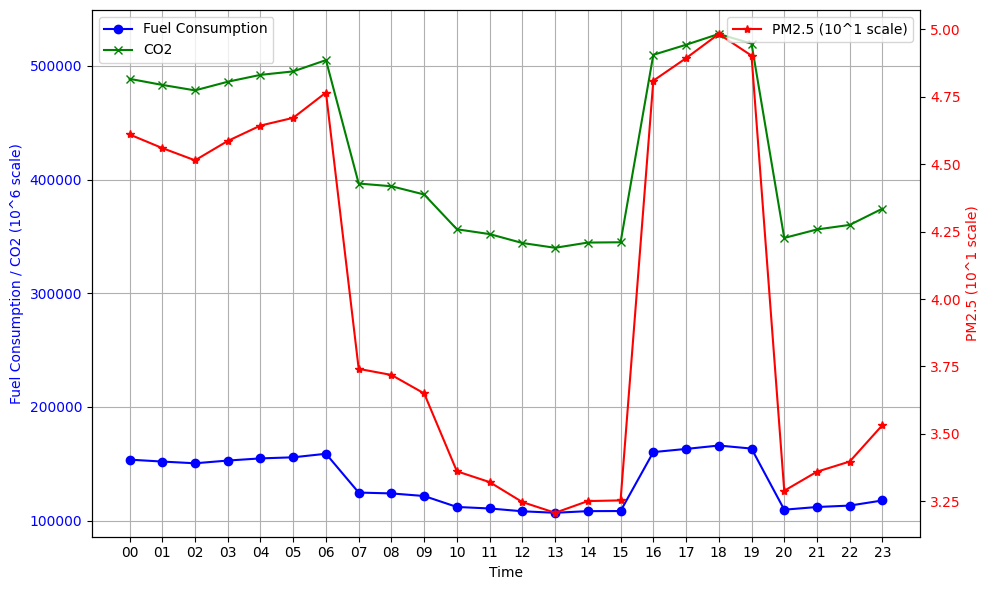

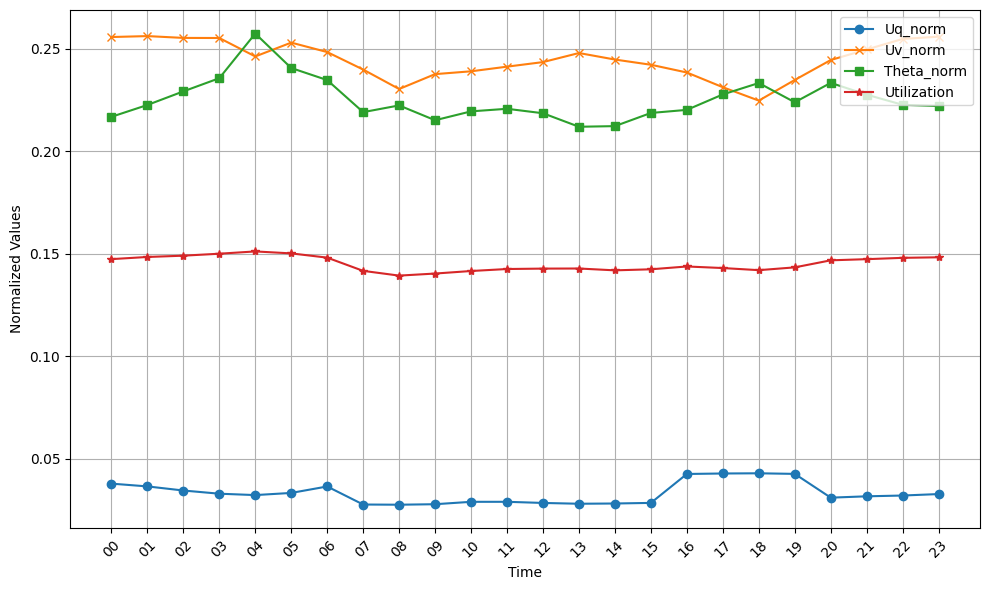

In [3]:
## Plot Data
def time_slot_to_hhmm(slot):
    hours = slot // 6  # Each 10-minute slot corresponds to 1/6th of an hour
    return f'{hours:02}'

    
# Step 2: Group by 'time' and calculate the mean of each column
aggregated_time_data = road_data.groupby('time').mean().reset_index()

# Step 3: Filter for only hourly data (slots: 0, 6, 12, ..., 138)
hourly_slots = aggregated_time_data[aggregated_time_data['time'] % 6 == 0]

# Convert time slots to 'HH:MM' format for x-axis labels
hourly_time_labels = hourly_slots['time'].apply(time_slot_to_hhmm)


# Step 5: Plot 1: fuel_consumption, co2, and pm2.5 with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis for fuel_consumption and co2
ax1.plot(hourly_time_labels, hourly_slots['fuel_consumption'], color='b', label='Fuel Consumption', marker='o')
ax1.plot(hourly_time_labels, hourly_slots['co2'], color='g', label='CO2', marker='x')

ax1.set_xlabel('Time')
ax1.set_ylabel('Fuel Consumption / CO2 (10^6 scale)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Secondary y-axis for pm2.5
ax2 = ax1.twinx()
ax2.plot(hourly_time_labels, hourly_slots['pm2.5'], color='r', label='PM2.5 (10^1 scale)', marker='*')
ax2.set_ylabel('PM2.5 (10^1 scale)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Save and show the first plot
plt.tight_layout()
plt.show()

# Step 6: Plot 2: Uq_norm, Uv_norm, theta_norm, utilization in one figure
plt.figure(figsize=(10, 6))

# Plot all columns in the same figure
plt.plot(hourly_time_labels, hourly_slots['Uq_norm'], label='Uq_norm', marker='o')
plt.plot(hourly_time_labels, hourly_slots['Uv_norm'], label='Uv_norm', marker='x')
plt.plot(hourly_time_labels, hourly_slots['theta_norm'], label='Theta_norm', marker='s')
plt.plot(hourly_time_labels, hourly_slots['utilization'], label='Utilization', marker='*')

# Add labels and grid
plt.xlabel('Time')
plt.ylabel('Normalized Values')
plt.grid(True)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add legend
plt.legend(loc='upper right')

# Save and show the second plot
plt.tight_layout()
plt.show()